In [ ]:
import numpy as np
#GP prior 
import matplotlib.pyplot as plt
from numpy.linalg import cholesky, solve

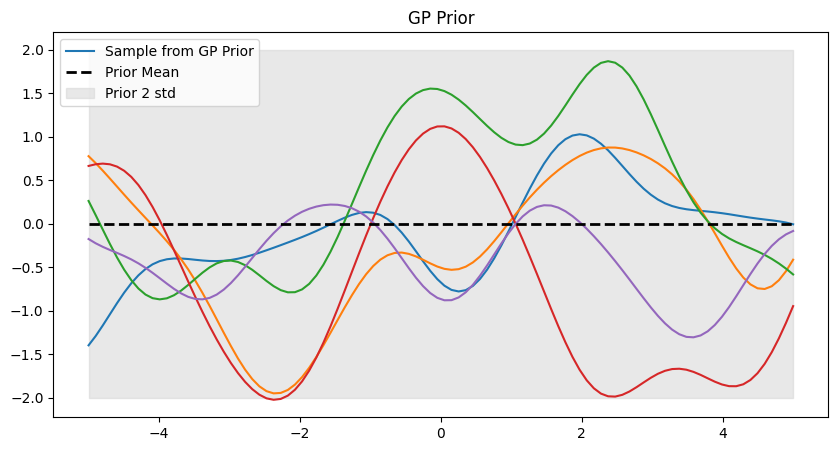

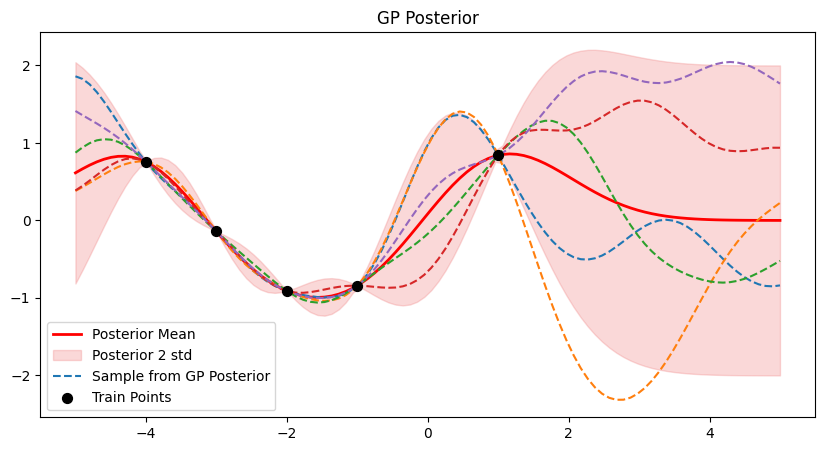

In [6]:
# Define the kernel (RBF)
def rbf_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    sqdist = np.subtract.outer(x1, x2)**2
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

# 1. GP Prior
X_ = np.linspace(-5, 5, 100)
K_ss = rbf_kernel(X_, X_)
L_prior = cholesky(K_ss + 1e-8 * np.eye(len(X_)))

n_prior_samples = 5
f_priors = np.random.multivariate_normal(mean=np.zeros(len(X_)), cov=K_ss + 1e-8 * np.eye(len(X_)), size=n_prior_samples).T

plt.figure(figsize=(10, 5))
for i in range(n_prior_samples):
    plt.plot(X_, f_priors[:, i], lw=1.5, label='Sample from GP Prior' if i == 0 else None)
plt.plot(X_, np.zeros_like(X_), 'k--', lw=2, label='Prior Mean')
plt.fill_between(X_, 
                 -2*np.sqrt(np.diag(K_ss)), 
                 2*np.sqrt(np.diag(K_ss)), 
                 color='lightgray', alpha=0.5, label='Prior 2 std')
plt.title('GP Prior')
plt.legend()
plt.show()

# 2. GP Posterior
# Training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
y_train = np.sin(X_train).ravel()

# Compute covariance matrices
K = rbf_kernel(X_train.ravel(), X_train.ravel())
K_s = rbf_kernel(X_train.ravel(), X_)
K_ss = rbf_kernel(X_, X_)

# Compute posterior mean and covariance
K_inv = np.linalg.inv(K + 1e-8 * np.eye(len(X_train)))
mu_s = K_s.T @ K_inv @ y_train
cov_s = K_ss - K_s.T @ K_inv @ K_s

# Draw samples from the posterior
L_post = cholesky(cov_s + 1e-8 * np.eye(len(X_)))
n_post_samples = 5
f_posts = mu_s[:, None] + np.dot(L_post, np.random.randn(len(X_), n_post_samples))

plt.figure(figsize=(10, 5))
plt.plot(X_, mu_s, 'r', lw=2, label='Posterior Mean')
plt.fill_between(X_, 
                 mu_s - 2*np.sqrt(np.diag(cov_s)), 
                 mu_s + 2*np.sqrt(np.diag(cov_s)), 
                 color='lightcoral', alpha=0.3, label='Posterior 2 std')


for i in range(n_post_samples):
    plt.plot(X_, f_posts[:, i], linestyle='--', lw=1.5, 
             label='Sample from GP Posterior' if i == 0 else None)

plt.scatter(X_train, y_train, c='black', s=50, zorder=10, label='Train Points')
plt.title('GP Posterior')
plt.legend()
plt.show()


In [7]:
K_s.shape

(5, 100)

In [11]:
mu_s.shape

(100,)

In [9]:
cov_s.shape

(100, 100)

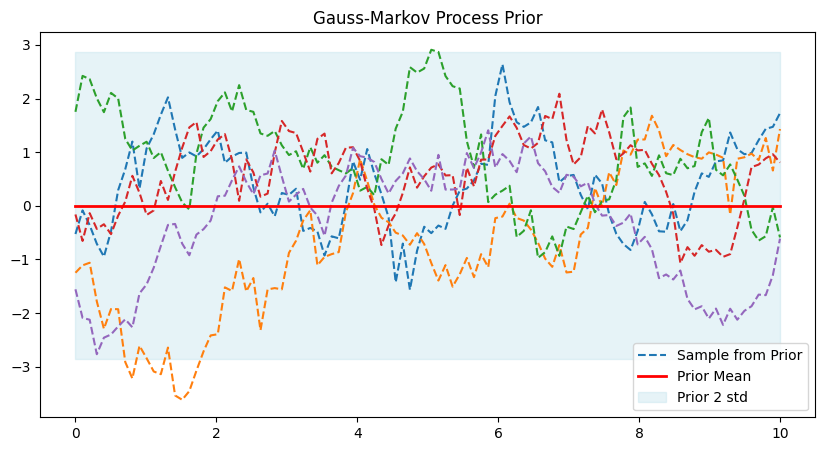

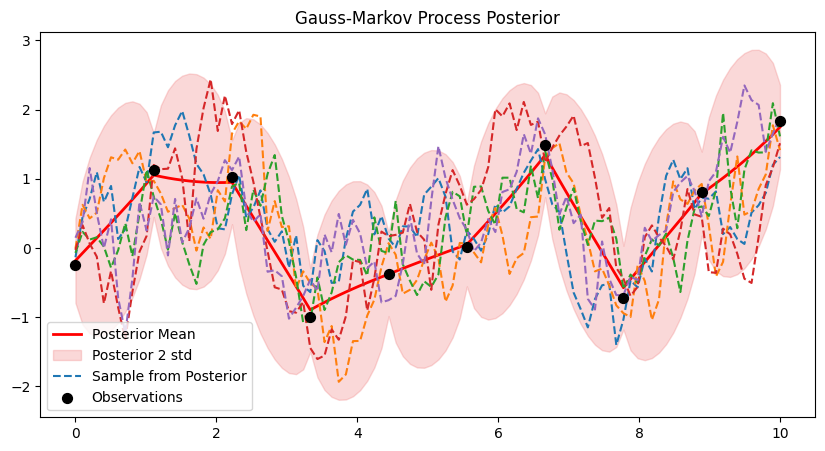

In [ ]:
# Define the time points
T = 100
t = np.linspace(0, 10, T)

# Gauss-Markov process: x_{t+1} = a * x_t + w_t, w_t ~ N(0, q)
a = 0.95
q = 0.2

# Construct the prior covariance matrix for the Gauss-Markov process
K_gm = np.zeros((T, T))
for i in range(T):
    for j in range(T):
        K_gm[i, j] = (q / (1 - a**2)) * a**(abs(i - j))

# Prior mean is zero
mu_gm = np.zeros(T)

# Draw samples from the prior
n_prior_samples = 5
L_gm = np.linalg.cholesky(K_gm + 1e-8 * np.eye(T))
x_prior_samples = mu_gm[:, None] + L_gm @ np.random.randn(T, n_prior_samples)

plt.figure(figsize=(10, 5))
for i in range(n_prior_samples):
    plt.plot(t, x_prior_samples[:, i], linestyle='--', lw=1.5, label='Sample from Prior' if i == 0 else None)
plt.plot(t, mu_gm, 'r', lw=2, label='Prior Mean')
plt.fill_between(t, 
                 mu_gm - 2*np.sqrt(np.diag(K_gm)), 
                 mu_gm + 2*np.sqrt(np.diag(K_gm)), 
                 color='lightblue', alpha=0.3, label='Prior 2 std')
plt.title('Gauss-Markov Process Prior')
plt.legend()
plt.show()

# Now, simulate some noisy observations at a few time points
obs_idx = np.linspace(0, T-1, 10, dtype=int)
x_true = x_prior_samples[:, 0]  # Use one prior sample as the "true" process
obs_noise = 0.1
y_obs = x_true[obs_idx] + np.random.randn(len(obs_idx)) * np.sqrt(obs_noise)

# Compute the posterior mean and covariance at all time points
K_oo = K_gm[np.ix_(obs_idx, obs_idx)]
K_ox = K_gm[np.ix_(obs_idx, np.arange(T))]
K_xo = K_gm[np.ix_(np.arange(T), obs_idx)]

K_oo_inv = np.linalg.inv(K_oo + obs_noise * np.eye(len(obs_idx)))
mu_post = mu_gm + K_xo @ K_oo_inv @ (y_obs - mu_gm[obs_idx])
cov_post = K_gm - K_xo @ K_oo_inv @ K_ox

# Draw samples from the posterior
L_post = np.linalg.cholesky(cov_post + 1e-8 * np.eye(T))
x_post_samples = mu_post[:, None] + L_post @ np.random.randn(T, n_prior_samples)

plt.figure(figsize=(10, 5))
plt.plot(t, mu_post, 'r', lw=2, label='Posterior Mean')
plt.fill_between(t, 
                 mu_post - 2*np.sqrt(np.diag(cov_post)), 
                 mu_post + 2*np.sqrt(np.diag(cov_post)), 
                 color='lightcoral', alpha=0.3, label='Posterior 2 std')
for i in range(n_prior_samples):
    plt.plot(t, x_post_samples[:, i], linestyle='--', lw=1.5, label='Sample from Posterior' if i == 0 else None)
plt.scatter(t[obs_idx], y_obs, c='black', s=50, zorder=10, label='Observations')
plt.title('Gauss-Markov Process Posterior')
plt.legend()
plt.show()
